# smrandom seq iM activity
Replicates the processing steps described in the original publication for the CIP time-course single-cell RNA-seq samples.

Gene identifiers from BW25113 are mapped to MG1655 (`b` numbers) using the provided BBH table.Quality-control follows the published cut-offs on total UMIs per time point and retains genes detected in ≥3 cells and cells with ≥10 detected genes.

Downstream, the notebook performs Scanpy normalisation, HVG detection with the reported parameters, PCA (svd_solver='arpack'), neighbours with `n_neighbors=10` and `n_pcs=4`, UMAP, Leiden clustering (resolution=1), and finally infers iModulon activities using the full normalised expression matrix.

In [1]:
# Imports and plotting defaults
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple

try:
    import seaborn as sns
except ImportError:
    sns = None

sc.settings.set_figure_params(dpi=100, facecolor='white')

In [2]:
# File locations and metadata
DATA_DIR = Path('smRandom_csv_matrix')
MAPPING_PATH = Path('BBH/BW25113_MG1655_BBH.tsv')
M_MATRIX_PATH = Path('P1K/P1K_M.csv')

accession_to_time = {
    'CRR794625': 'CIP_0h',
    'CRR794626': 'CIP_1h',
    'CRR794627': 'CIP_2h',
    'CRR794628': 'CIP_4h',
}
condition_order = ['CIP_0h', 'CIP_1h', 'CIP_2h', 'CIP_4h']


In [3]:
# Load BW25113 → MG1655 mapping (using best bidirectional hits)
bw_to_mg = (
    pd.read_csv(MAPPING_PATH, sep='	', usecols=['query_gene_id', 'subject_gene_id'])
    .drop_duplicates(subset='query_gene_id')
    .set_index('query_gene_id')['subject_gene_id']
)
print(f"Loaded {bw_to_mg.size:,} BW25113 → MG1655 gene mappings")


Loaded 4,206 BW25113 → MG1655 gene mappings


In [4]:
# Helper to load one matrix, map to MG1655 genes, and attach metadata
def load_sample(accession: str, time_point: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    matrix_path = DATA_DIR / f"{accession}_filtered_feature_bc_matrix.csv"
    counts = pd.read_csv(matrix_path, index_col=0)

    overlapping = counts.columns.intersection(bw_to_mg.index)
    if overlapping.empty:
        raise ValueError(f'No BW25113 → MG1655 mappings for any genes in {accession}')

    counts = counts.loc[:, overlapping].copy()
    counts.columns = counts.columns.map(bw_to_mg)
    counts = counts.groupby(level=0, axis=1).sum()

    barcodes = counts.index.astype(str)
    cell_ids = pd.Index([f"{accession}_{bc}" for bc in barcodes], name='cell_id')
    counts.index = cell_ids

    obs = pd.DataFrame({
        'accession': accession,
        'time_point': time_point,
        'barcode': barcodes,
    }, index=cell_ids)

    print(f"{accession} ({time_point}): {counts.shape[0]:,} cells × {counts.shape[1]:,} mapped genes")
    return counts, obs


In [5]:
# Load all four samples
counts_list = []
obs_list = []
for accession, time_point in accession_to_time.items():
    counts, obs = load_sample(accession, time_point)
    counts_list.append(counts)
    obs_list.append(obs)

counts_df = pd.concat(counts_list, axis=0).fillna(0)
counts_df = counts_df.astype(np.int32)
obs_df = pd.concat(obs_list, axis=0)

print(f'Combined matrix: {counts_df.shape[0]:,} cells × {counts_df.shape[1]:,} genes before QC filters')


/tmp/ipykernel_2873992/3250542050.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  counts = counts.groupby(level=0, axis=1).sum()


CRR794625 (CIP_0h): 10,000 cells × 4,186 mapped genes


/tmp/ipykernel_2873992/3250542050.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  counts = counts.groupby(level=0, axis=1).sum()


CRR794626 (CIP_1h): 10,000 cells × 4,186 mapped genes


/tmp/ipykernel_2873992/3250542050.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  counts = counts.groupby(level=0, axis=1).sum()


CRR794627 (CIP_2h): 10,000 cells × 4,186 mapped genes


/tmp/ipykernel_2873992/3250542050.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  counts = counts.groupby(level=0, axis=1).sum()


CRR794628 (CIP_4h): 10,000 cells × 4,186 mapped genes
Combined matrix: 40,000 cells × 4,186 genes before QC filters


Remaining: 25,133 cells × 4,186 genes after QC filters


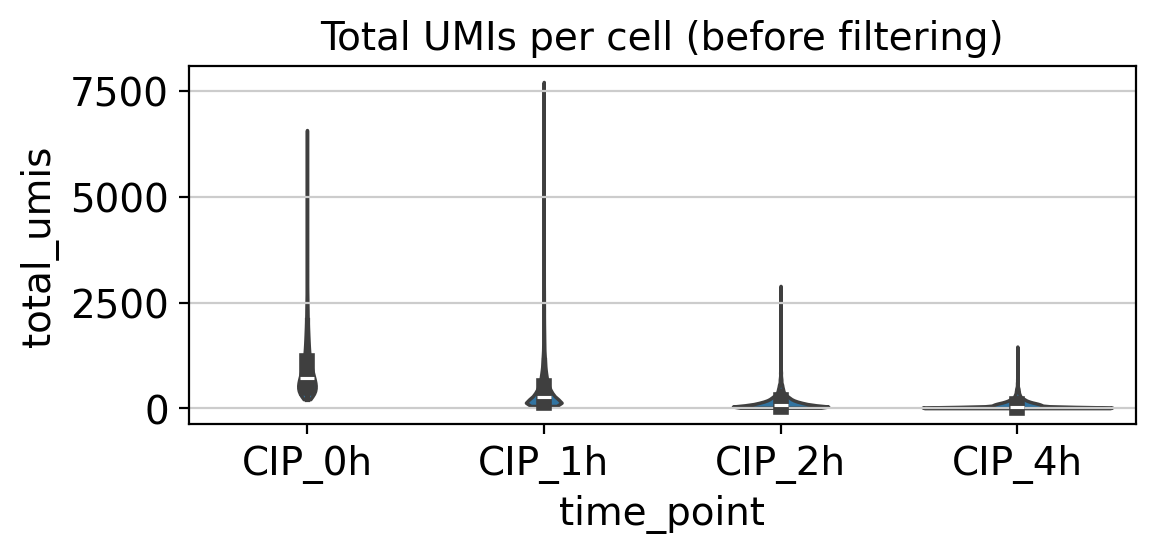

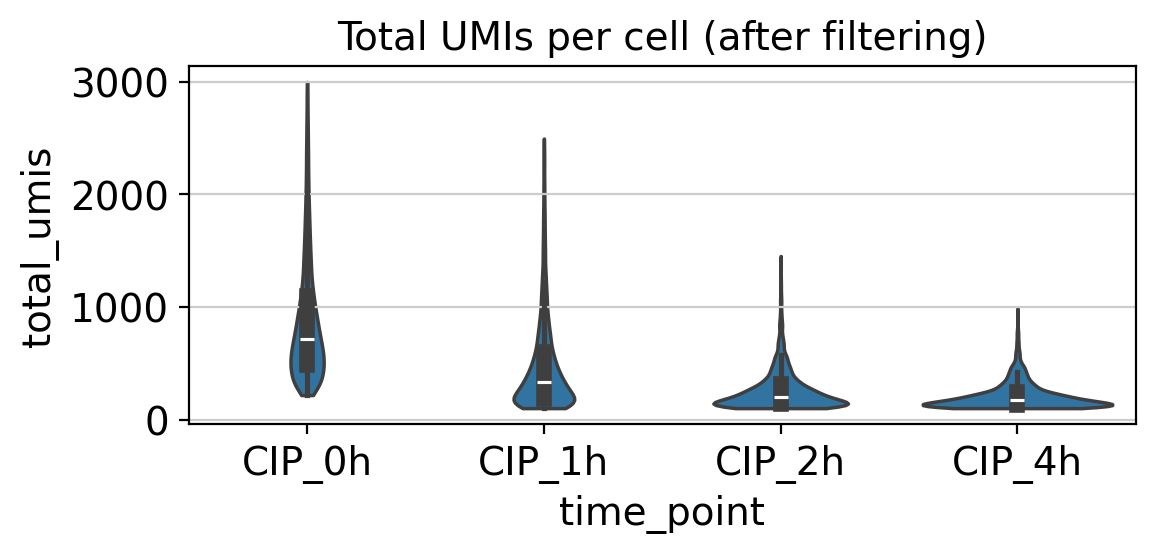

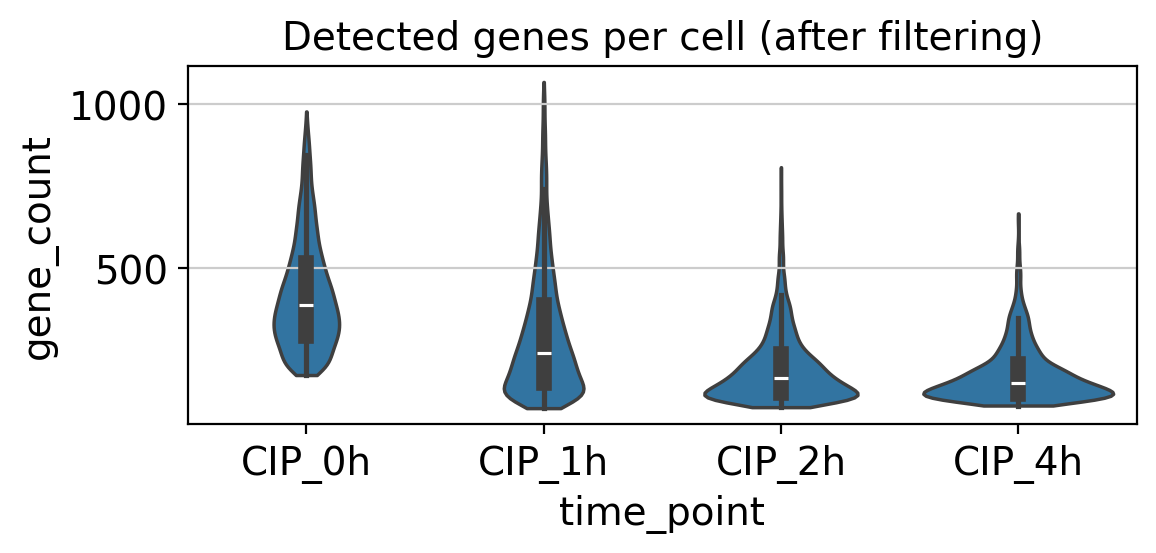

In [6]:
# Published UMI-based QC filters
obs_df['total_umis'] = counts_df.sum(axis=1)
obs_df['time_point'] = pd.Categorical(obs_df['time_point'], categories=condition_order, ordered=True)

if sns is not None:
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=obs_df, x='time_point', y='total_umis', cut=0)
    plt.title('Total UMIs per cell (before filtering)')
    plt.tight_layout()
else:
    print('Install seaborn to reproduce violin plots of UMI distributions.')

mask = (obs_df['total_umis'] > 100) & (obs_df['total_umis'] < 3000)
obs_df = obs_df.loc[mask]
counts_df = counts_df.loc[obs_df.index]

max_umi_thresholds = {'CIP_2h': 1500, 'CIP_1h': 2500, 'CIP_4h': 1000}
for time_point, max_umis in max_umi_thresholds.items():
    to_keep = ~((obs_df['time_point'] == time_point) & (obs_df['total_umis'] > max_umis))
    obs_df = obs_df.loc[to_keep]
    counts_df = counts_df.loc[obs_df.index]

obs_df['gene_count'] = (counts_df > 0).sum(axis=1)

if sns is not None:
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=obs_df, x='time_point', y='total_umis', cut=0)
    plt.title('Total UMIs per cell (after filtering)')
    plt.tight_layout()
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=obs_df, x='time_point', y='gene_count', cut=0)
    plt.title('Detected genes per cell (after filtering)')
    plt.tight_layout()

print(f'Remaining: {counts_df.shape[0]:,} cells × {counts_df.shape[1]:,} genes after QC filters')


In [7]:
# Create AnnData object and align with P1K M matrix genes
var = pd.DataFrame(index=counts_df.columns, data={'mg1655_gene': counts_df.columns})
adata = ad.AnnData(X=counts_df.to_numpy(dtype=np.float32), obs=obs_df, var=var)
adata.obs['time'] = adata.obs['time_point'].astype(str)
adata.obs_names.name = 'cell_id'
adata.var_names.name = 'mg1655_gene'
adata.layers['counts'] = adata.X.copy()
adata.var_names_make_unique()

M = pd.read_csv(M_MATRIX_PATH, index_col=0)
shared_genes = adata.var_names.intersection(M.index, sort=False)
if shared_genes.empty:
    raise ValueError('No genes overlap between the single-cell data and the P1K iModulon M matrix')

adata = adata[:, shared_genes].copy()
adata.layers['counts'] = adata.X.copy()
M = M.loc[shared_genes]
print(f"Aligned AnnData: {adata.n_obs:,} cells × {adata.n_vars:,} shared genes")


Aligned AnnData: 25,133 cells × 4,095 shared genes


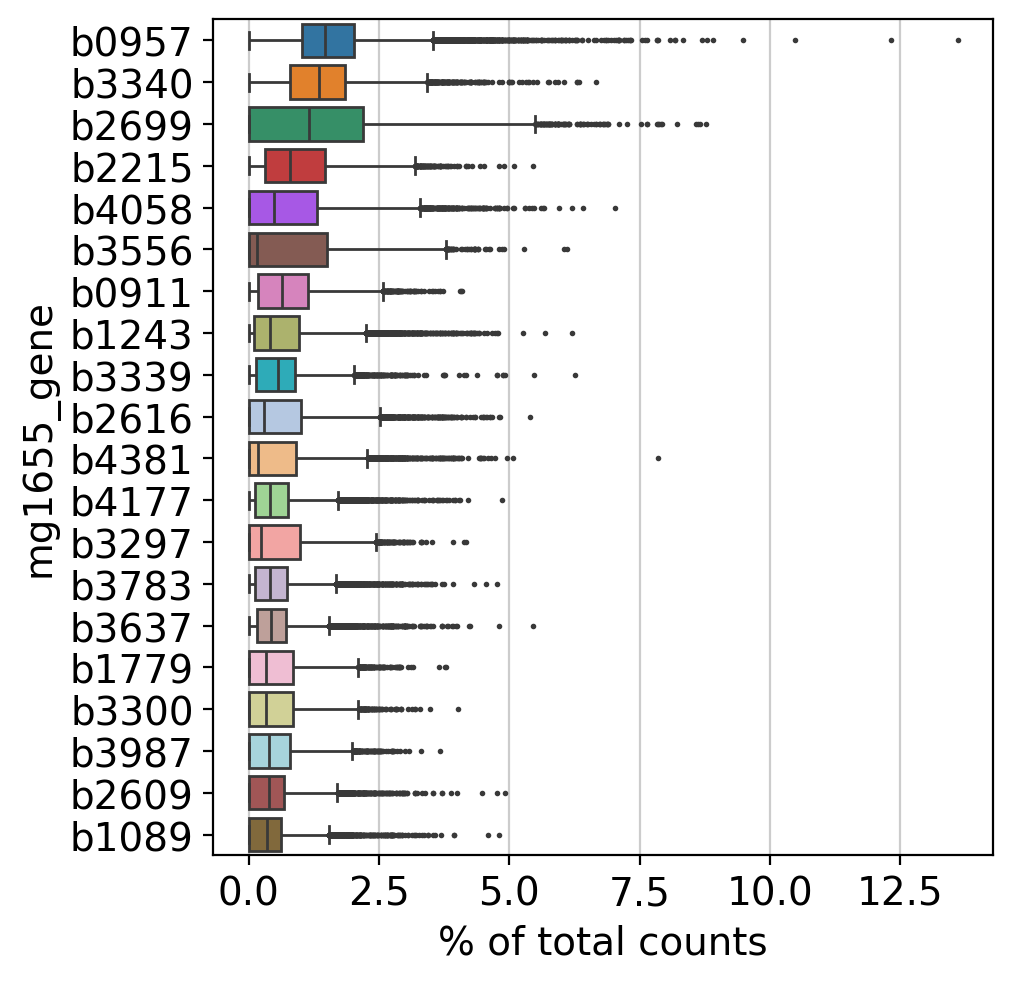

In [8]:
# Highest expressed genes across cells
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
# Low-quality cell/gene filtering
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)
M = M.loc[adata.var_names]
print(f"Post-filtering: {adata.n_obs:,} cells × {adata.n_vars:,} genes")


Post-filtering: 25,133 cells × 4,095 genes


In [10]:
# Normalisation and log-transformation
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_normalized'] = adata.X.copy()
adata.raw = adata


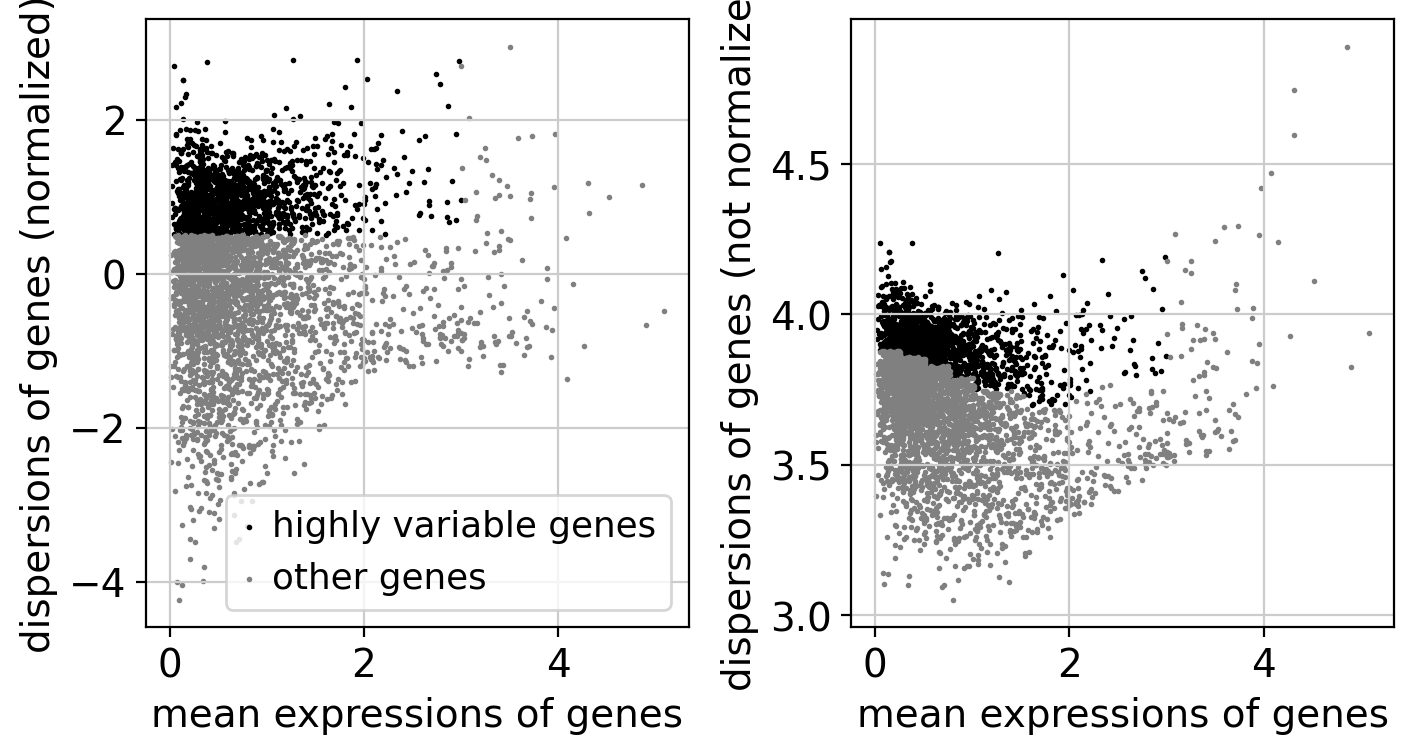

In [11]:
# Highly variable genes (paper parameters)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


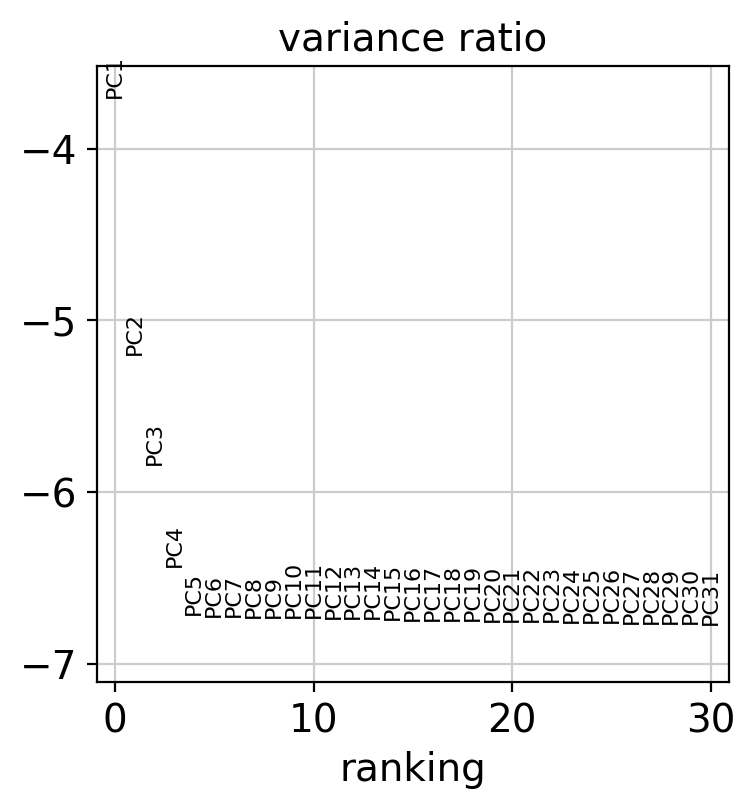

In [12]:
# Scaling, PCA, and variance explained
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)


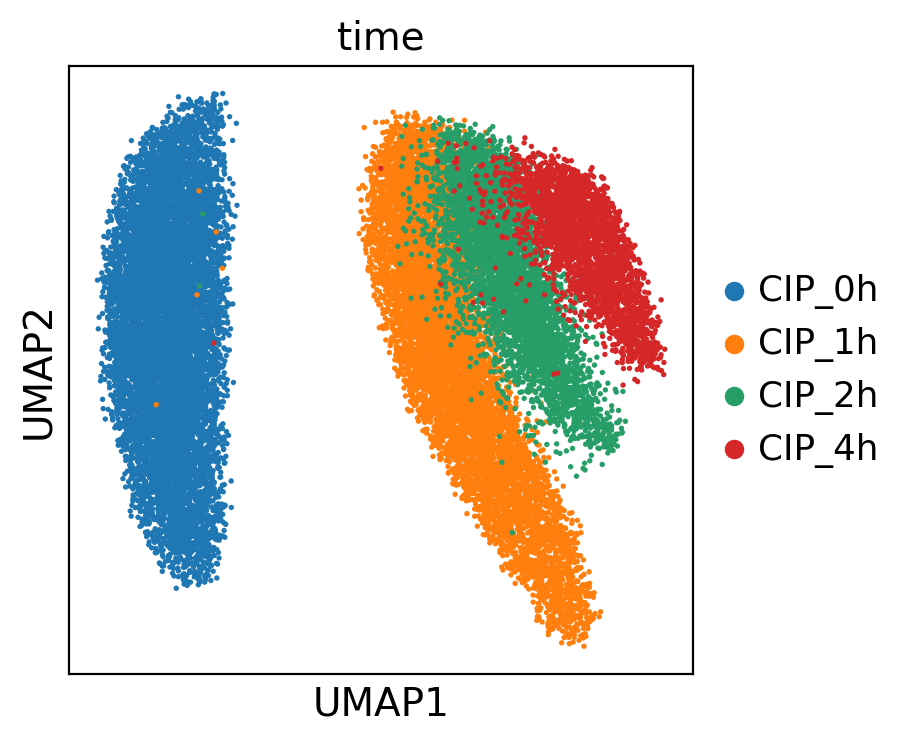

/tmp/ipykernel_2873992/3916254688.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0)


In [13]:
# Neighbour graph, UMAP, and Leiden clustering
n_pcs = min(10, adata.obsm['X_pca'].shape[1])
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.7, spread=0.5)
sc.pl.umap(adata, color='time', size=15)
sc.tl.leiden(adata, resolution=1.0)
# 

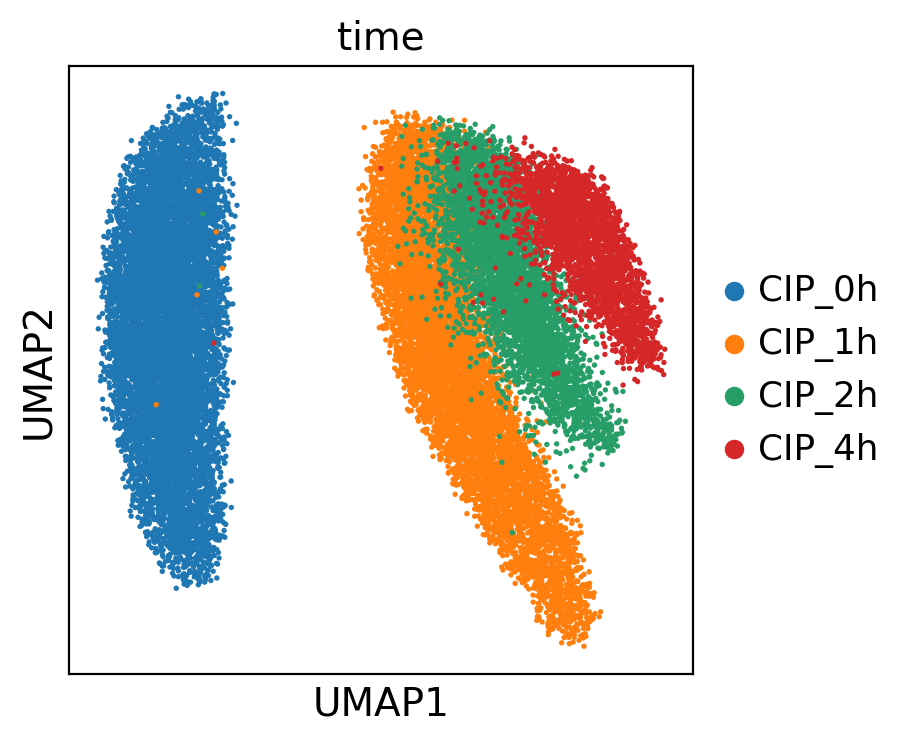

In [71]:
sc.pl.umap(adata, color='time', size=15)

In [79]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import PathCollection
from matplotlib.figure import Figure
from typing import Optional, Tuple


def save_umap_time(
    adata,
    save_path: Optional[str] = None,
    font_path: str = "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf",
    figsize: Tuple[float, float] = (6, 5),
    size: int = 15,
):
    """
    Produce sc.pl.umap(adata, color='time'), remove title, apply Arial font to all text
    (axes, ticks, legend), show it, and optionally save with rasterized scatter.
    """

    font_prop = fm.FontProperties(fname=font_path)

    # Create plot with controlled figsize
    with plt.rc_context({"figure.figsize": figsize}):
        fig = sc.pl.umap(
            adata,
            color="time",
            size=size,
            show=False,
            return_fig=True,
        )

    # Scanpy may return (fig, ax_list)
    if isinstance(fig, tuple):
        fig = fig[0]
    if not isinstance(fig, Figure):
        raise TypeError(f"Unexpected object returned: {type(fig)}")

    # Axes text: labels, ticks, embedded texts
    for ax in fig.axes:
        # Remove title ("time")
        ax.set_title("Time")

        # Axis labels (UMAP1 / UMAP2)
        xlab = ax.get_xlabel()
        ylab = ax.get_ylabel()
        if xlab:
            ax.set_xlabel(xlab, fontproperties=font_prop)
        if ylab:
            ax.set_ylabel(ylab, fontproperties=font_prop)

        # Tick labels
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(font_prop)

        # Any text objects inside the axis
        for txt in ax.texts:
            txt.set_fontproperties(font_prop)

        # Legend attached to this axis (for categorical "time")
        leg = ax.get_legend()
        if leg is not None:
            # Legend title
            leg_title = leg.get_title()
            if leg_title is not None:
                leg_title.set_fontproperties(font_prop)
            # Legend labels
            for txt in leg.get_texts():
                txt.set_fontproperties(font_prop)

    # Also handle figure-level legends if any
    for leg in fig.legends:
        leg_title = leg.get_title()
        if leg_title is not None:
            leg_title.set_fontproperties(font_prop)
        for txt in leg.get_texts():
            txt.set_fontproperties(font_prop)

    # Show in notebook
    fig.show()

    # Save and rasterize scatter points only
    if save_path is not None:
        for ax in fig.axes:
            for coll in ax.collections:
                if isinstance(coll, PathCollection):
                    coll.set_rasterized(True)
        fig.savefig(save_path, bbox_inches="tight")

    return fig


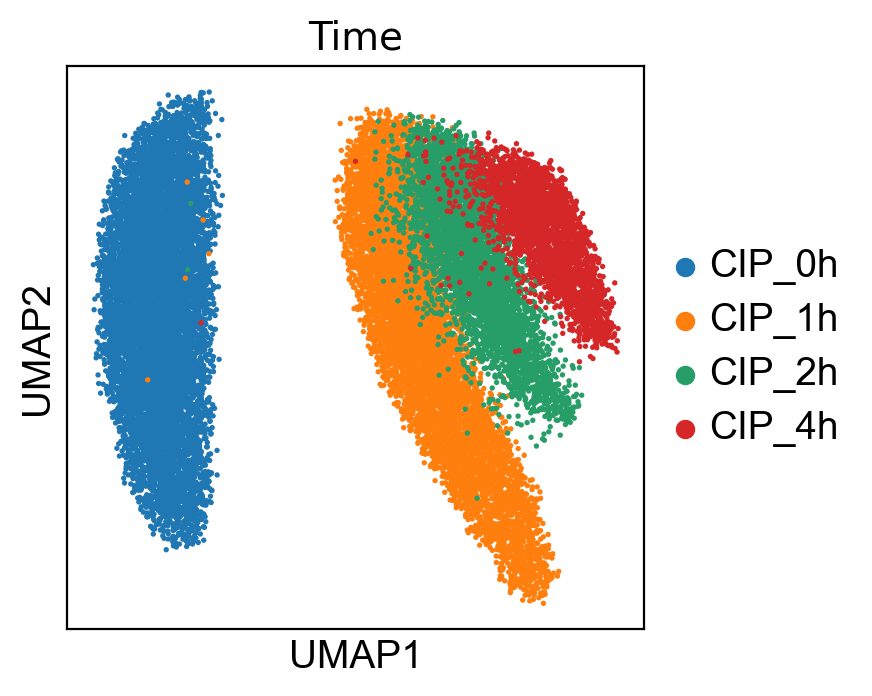

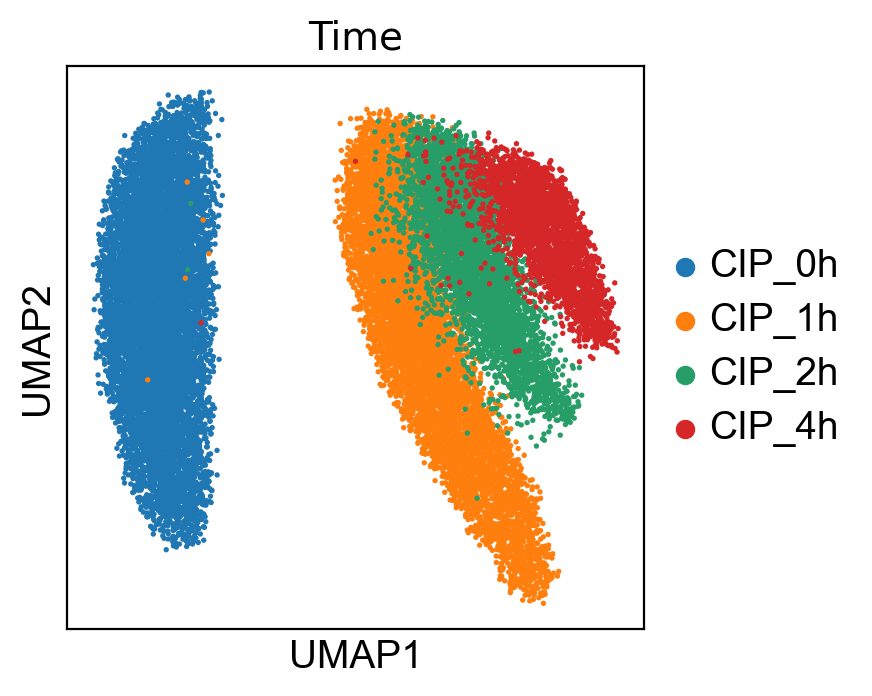

In [80]:
save_umap_time(
    adata,
    save_path="umap_time.svg",
    figsize=(3.7, 3.7),
    size=15,
)

In [14]:
# Infer iModulon activities using the full log-normalised matrix
log_norm = adata.layers['log_normalized']  # cells × genes
X = log_norm.T  # genes × cells
# A = M.to_numpy().T @ X
A = pinv(M) @ X
activity_df = pd.DataFrame(A.T, index=adata.obs_names, columns=M.columns)

adata.obsm['iModulon_activity'] = activity_df.to_numpy(dtype=np.float32)
adata.uns['iModulon_names'] = activity_df.columns.tolist()
activity_df.head()

Sugar Diacid  Translation      ygdT      OxyR  \
cell_id                                                                         
CRR794625_AACCGACCTACGCTCGCGGT     -0.899863    24.516863 -0.918804  0.789654   
CRR794625_AACCGACCTAGGTCCGCGGT     -0.753205    19.091035 -0.192712  1.194962   
CRR794625_AACCGACGATCTAACGCGGT     -0.827672    22.286286 -0.466528  0.898038   
CRR794625_AACCGACGATCTCCAGCGGT      0.616118    22.111258 -0.515815 -0.143304   
CRR794625_AACCGACTAAGTAGAGCGGT     -0.291100    22.247587 -1.308738  1.153859   

                                 FlhDC-2  Osmoprotectant  Glutamine  \
cell_id                                                               
CRR794625_AACCGACCTACGCTCGCGGT -0.967782        0.053616   0.356644   
CRR794625_AACCGACCTAGGTCCGCGGT -0.698876       -0.264854   0.295651   
CRR794625_AACCGACGATCTAACGCGGT -0.576895        0.161602   0.965233   
CRR794625_AACCGACGATCTCCAGCGGT -0.452214        0.964104   1.673675   
CRR794625_AACCGACTAAGTAGAGCGGT -0.393751        1.413863   0.959273   

                                Sialic Acid      yqhI  ROS TALE Amp  ...  \
cell_id                                                              ...   
CRR794625_AACCGACCTACGCTCGCGGT    -2.030369  0.644340     -0.954776  ...   
CRR794625_AACCGACCTAGGTCCGCGGT    -1.109908  0.992994     -0.811886  ...   
CRR794625_AACCGACGATCTAACGCGGT    -1.184355 -0.371566     -1.877952  ...   
CRR794625_AACCGACGATCTCCAGCGGT    -1.200463  0.611723     -0.763960  ...   
CRR794625_AACCGACTAAGTAGAGCGGT    -2.504366  0.651343     -2.201279  ...   

                                Tryptophanase  crp KO-2  cyoB/ndh/nuoB KO-2  \
cell_id                                                                       
CRR794625_AACCGACCTACGCTCGCGGT      -0.139862 -0.550032            4.295012   
CRR794625_AACCGACCTAGGTCCGCGGT       1.220240 -0.326828            1.478813   
CRR794625_AACCGACGATCTAACGCGGT      -0.495228 -1.558393            3.252726   
CRR794625_AACCGACGATCTCCAGCGGT       1.473183 -0.825784            1.691575   
CRR794625_AACCGACTAAGTAGAGCGGT       0.079547 -0.559086            3.564062   

                                 tpiA KO  Phage Shock  Glyoxylate  \
cell_id                                                             
CRR794625_AACCGACCTACGCTCGCGGT  0.916243    -0.629397    0.135344   
CRR794625_AACCGACCTAGGTCCGCGGT -0.576129     0.686845   -0.130653   
CRR794625_AACCGACGATCTAACGCGGT  0.462094    -0.392626    1.368590   
CRR794625_AACCGACGATCTCCAGCGGT  0.183617     0.026058    1.434647   
CRR794625_AACCGACTAAGTAGAGCGGT  0.056962     0.227208    0.380031   

                                CCK-PGI Del   Acetate   Ile/Val      UC-8  
cell_id                                                                    
CRR794625_AACCGACCTACGCTCGCGGT    -2.306896  0.971566 -0.856960 -3.199496  
CRR794625_AACCGACCTAGGTCCGCGGT    -1.041220  0.571527  0.012610 -0.458194  
CRR794625_AACCGACGATCTAACGCGGT    -0.874323 -0.206001 -1.159878 -1.452817  
CRR794625_AACCGACGATCTCCAGCGGT    -1.995271  0.541259 -0.948472 -2.077015  
CRR794625_AACCGACTAAGTAGAGCGGT    -1.793635  0.823317 -0.097653 -2.363202  

[5 rows x 201 columns]

In [63]:
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import PathCollection
from matplotlib.figure import Figure
from typing import Optional, Tuple


def plot_imodulon_activity(
    adata_obj: ad.AnnData,
    imodulon_name: str,
    cmap: str = 'viridis',
    save_path: Optional[str] = None,
    font_path: str = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf',
    figsize: Tuple[float, float] = (6, 5),
) -> None:
    """
    Plot UMAP for a given iModulon, show it in the notebook, and optionally
    save an SVG with rasterized points. All text uses the given font.
    """

    # Load font
    font_prop = fm.FontProperties(fname=font_path)

    # Checks
    if 'iModulon_activity' not in adata_obj.obsm or 'iModulon_names' not in adata_obj.uns:
        raise KeyError('Run activity inference before plotting iModulon activities')

    imod_names = adata_obj.uns['iModulon_names']
    if imodulon_name not in imod_names:
        preview = ', '.join(list(imod_names[:8]))
        raise ValueError(f"{imodulon_name!r} not not found. Example names: {preview} ...")

    idx = imod_names.index(imodulon_name)
    activity_key = f"{imodulon_name}_activity"

    # Temporary write activity
    if activity_key not in adata_obj.obs:
        adata_obj.obs[activity_key] = adata_obj.obsm['iModulon_activity'][:, idx]

    # Create the plot with a temporary figsize
    with plt.rc_context({"figure.figsize": figsize}):
        fig = sc.pl.umap(
            adata_obj,
            color=activity_key,
            color_map=cmap,
            colorbar_loc='right',
            title=f"{imodulon_name} iModulon Activity",
            show=False,
            return_fig=True,
        )

    # Scanpy may return fig or (fig, ax_list)
    if isinstance(fig, tuple):
        fig = fig[0]
    if not isinstance(fig, Figure):
        raise TypeError(f"Unexpected object returned from sc.pl.umap: {type(fig)}")

    # Apply custom font to all axes
    for ax in fig.axes:
        # Title
        title_text = ax.get_title()
        if title_text:
            ax.set_title(title_text, fontproperties=font_prop)

        # Axis labels
        xlab = ax.get_xlabel()
        ylab = ax.get_ylabel()
        if xlab:
            ax.set_xlabel(xlab, fontproperties=font_prop)
        if ylab:
            ax.set_ylabel(ylab, fontproperties=font_prop)

        # Tick labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(font_prop)

        # Any additional text within the axes
        for txt in ax.texts:
            txt.set_fontproperties(font_prop)

    # Show in notebook
    fig.show()

    # Save with rasterized points if requested
    if save_path is not None:
        for ax in fig.axes:
            for coll in ax.collections:
                if isinstance(coll, PathCollection):
                    coll.set_rasterized(True)
        fig.savefig(save_path, bbox_inches='tight')

    # Clean up temporary column
    adata_obj.obs.drop(columns=[activity_key], inplace=True, errors='ignore')


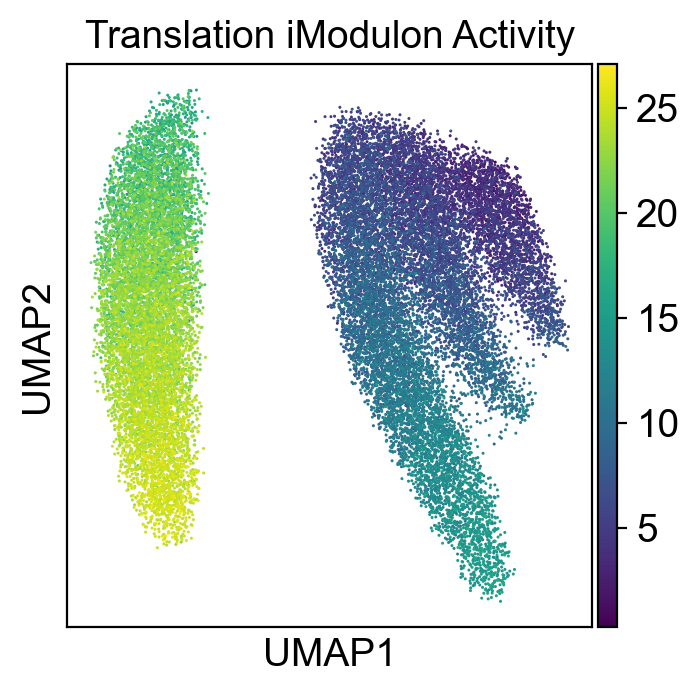

In [81]:
plot_imodulon_activity(
    adata,
    'Translation',
    cmap='viridis',
    figsize=(3.7, 3.7),
    save_path='Translation_smRandom.svg',
)

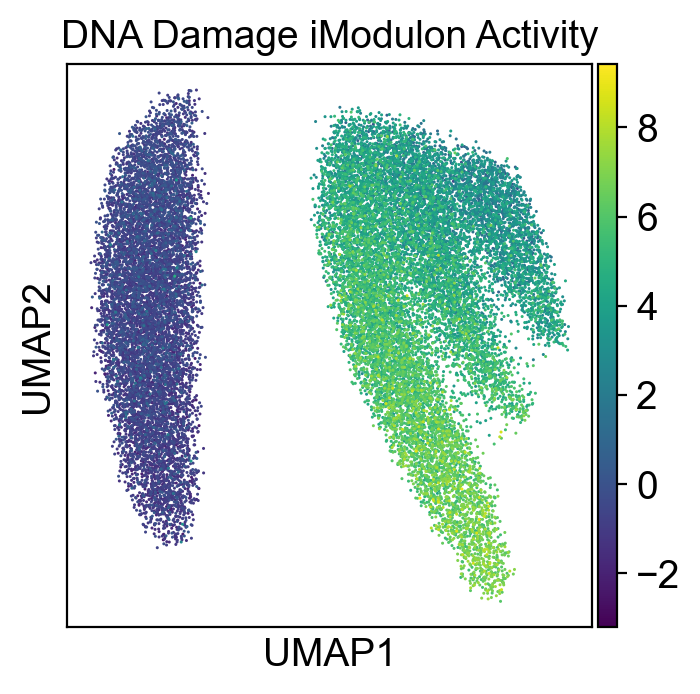

In [69]:
plot_imodulon_activity(adata, 'DNA Damage',
    figsize=(3.7, 3.7),
    save_path='DNA_Damage_smRandom.svg')

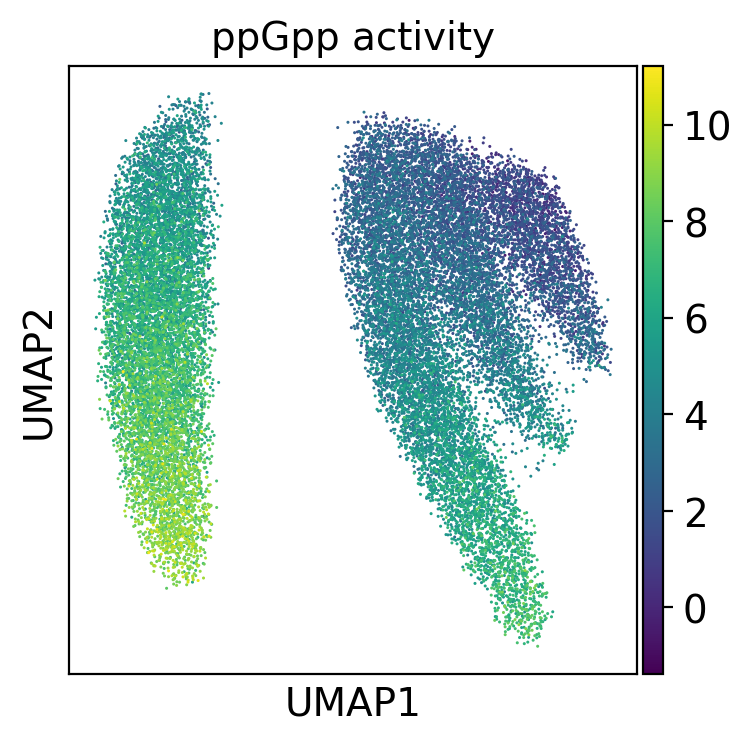

In [43]:
plot_imodulon_activity(adata, 'ppGpp')

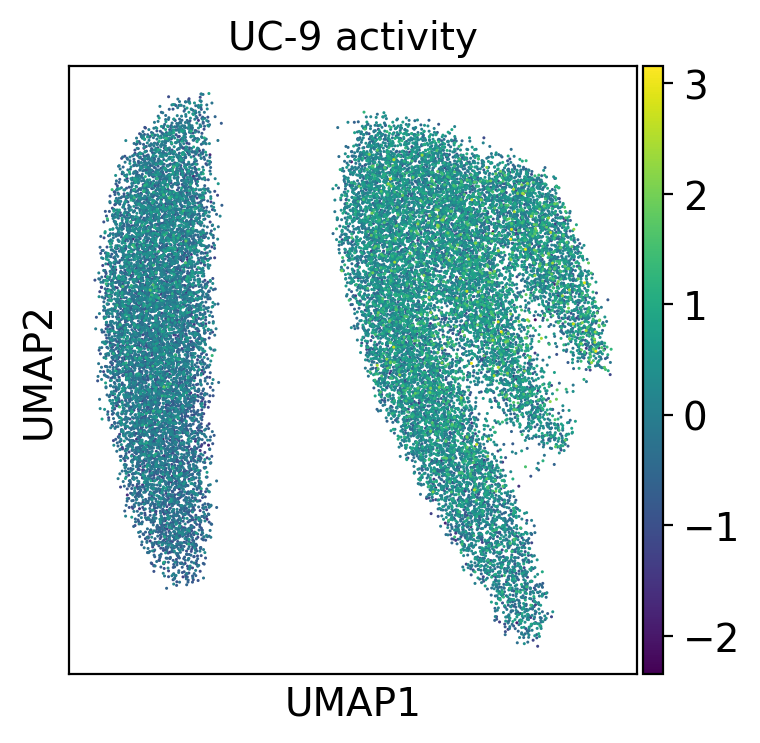

In [18]:
plot_imodulon_activity(adata, 'UC-9')

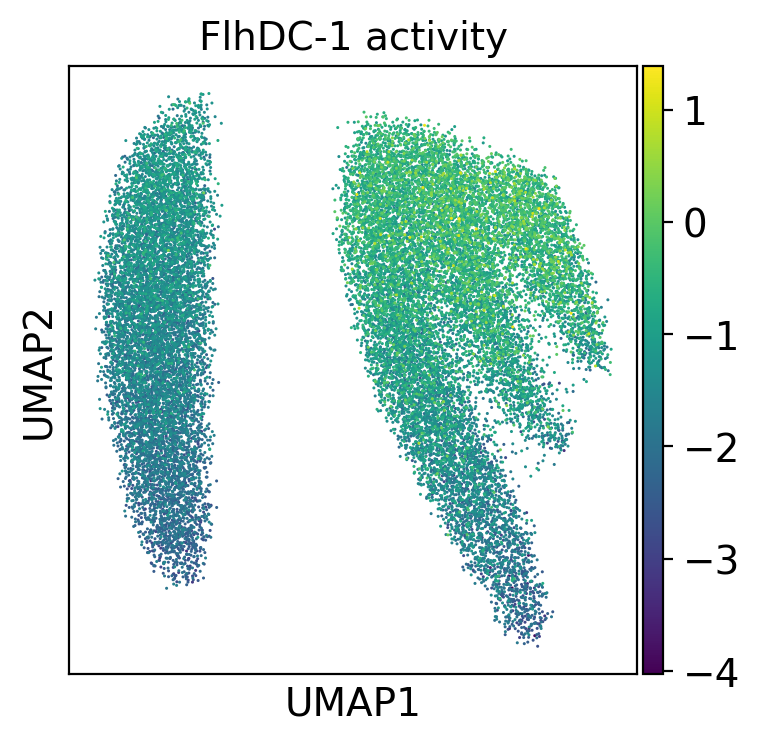

In [19]:
plot_imodulon_activity(adata, 'FlhDC-1')

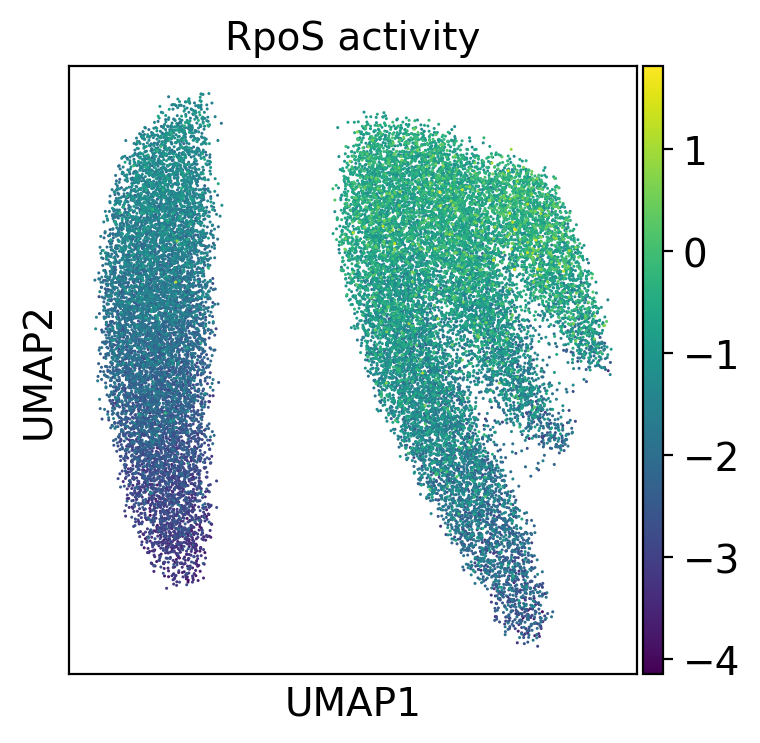

In [20]:
plot_imodulon_activity(adata, 'RpoS')

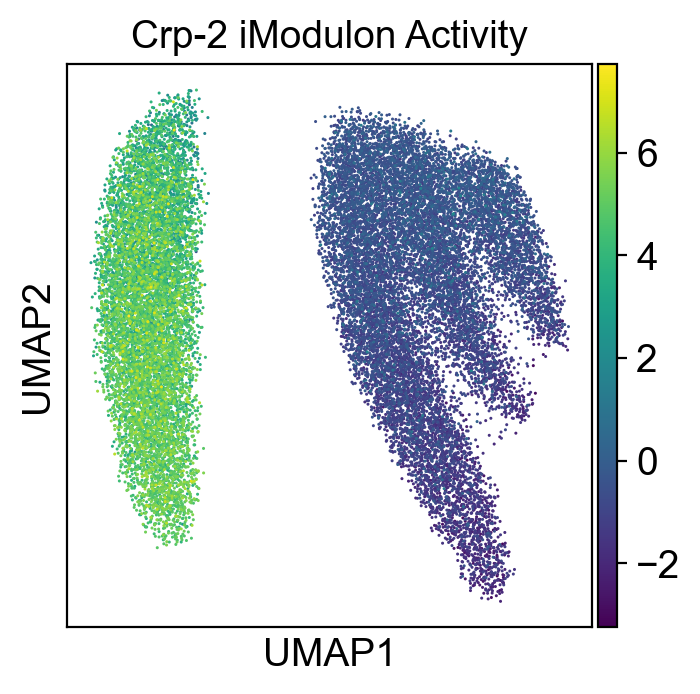

In [86]:
plot_imodulon_activity(adata, 'Crp-2', figsize=(3.7, 3.7))

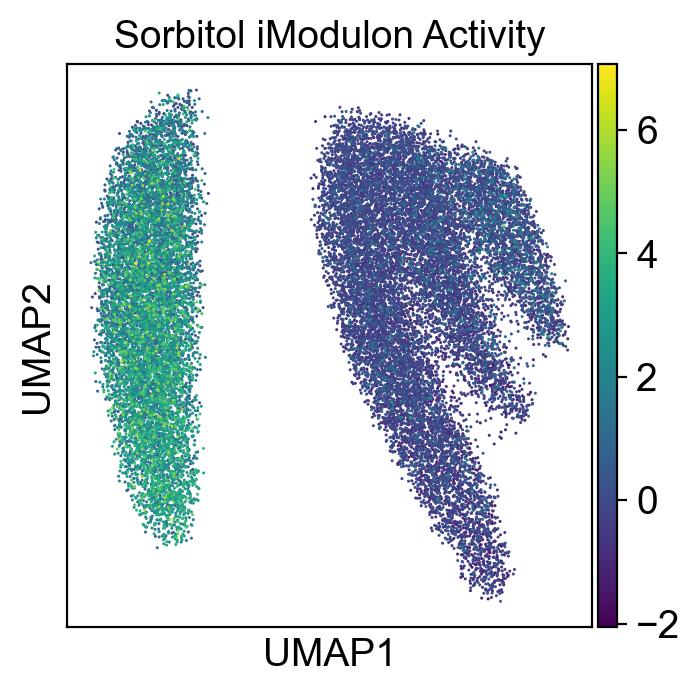

In [113]:
plot_imodulon_activity(adata, 'Sorbitol', figsize=(3.7, 3.7))

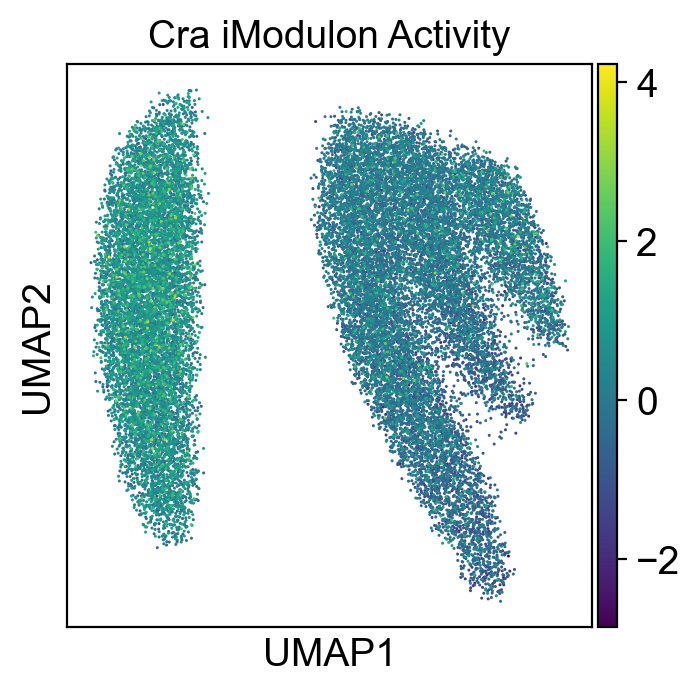

In [91]:
plot_imodulon_activity(adata, 'Cra', figsize=(3.7, 3.7))

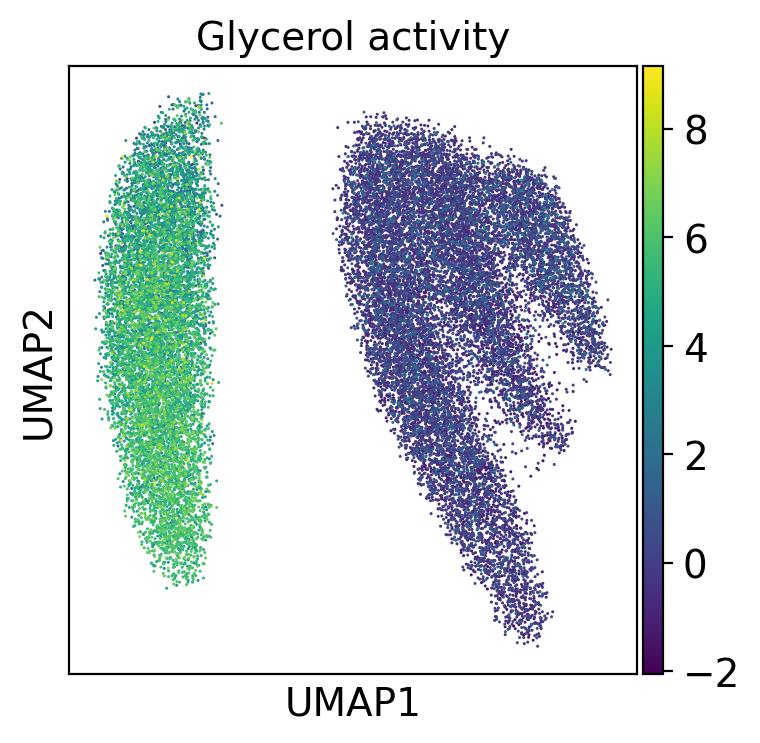

In [22]:
plot_imodulon_activity(adata, 'Glycerol')

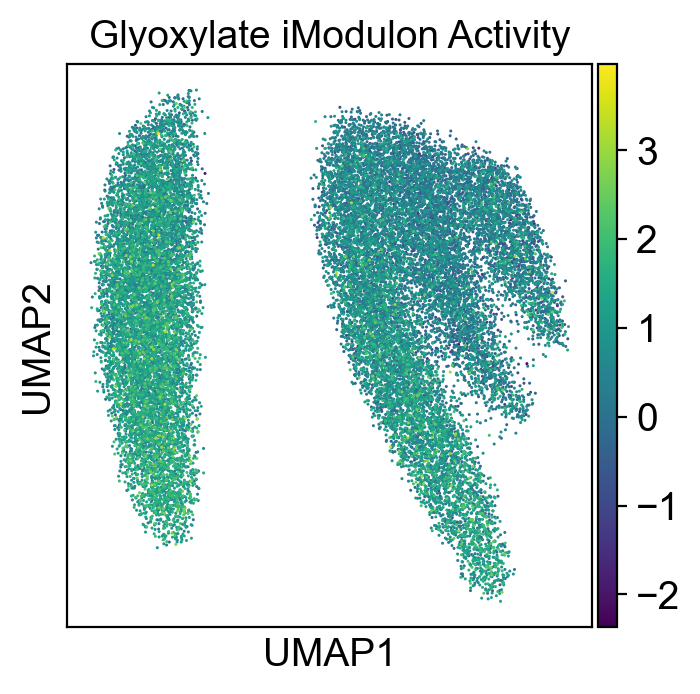

In [90]:
plot_imodulon_activity(adata, 'Glyoxylate', figsize=(3.7, 3.7))

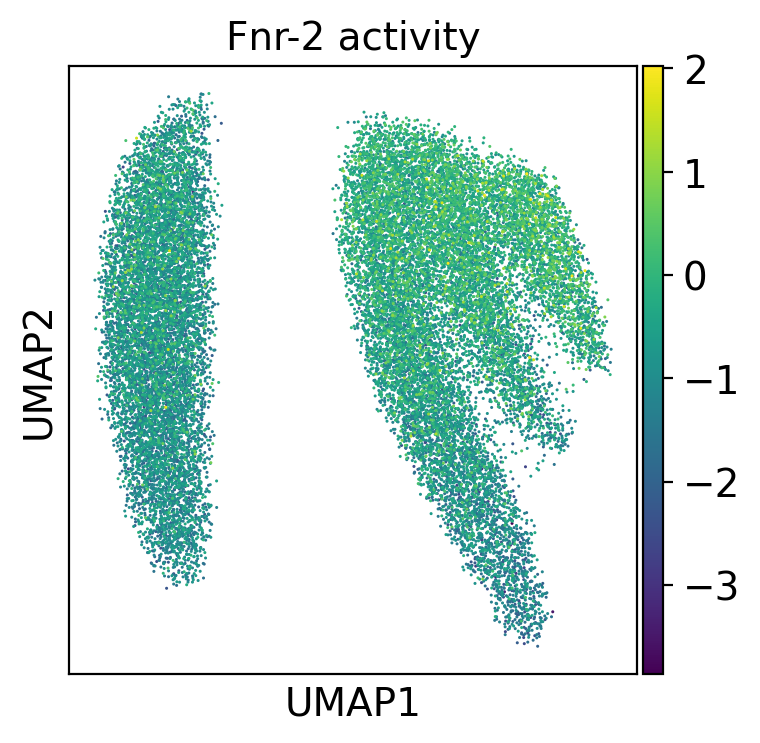

In [25]:
plot_imodulon_activity(adata, 'Fnr-2')

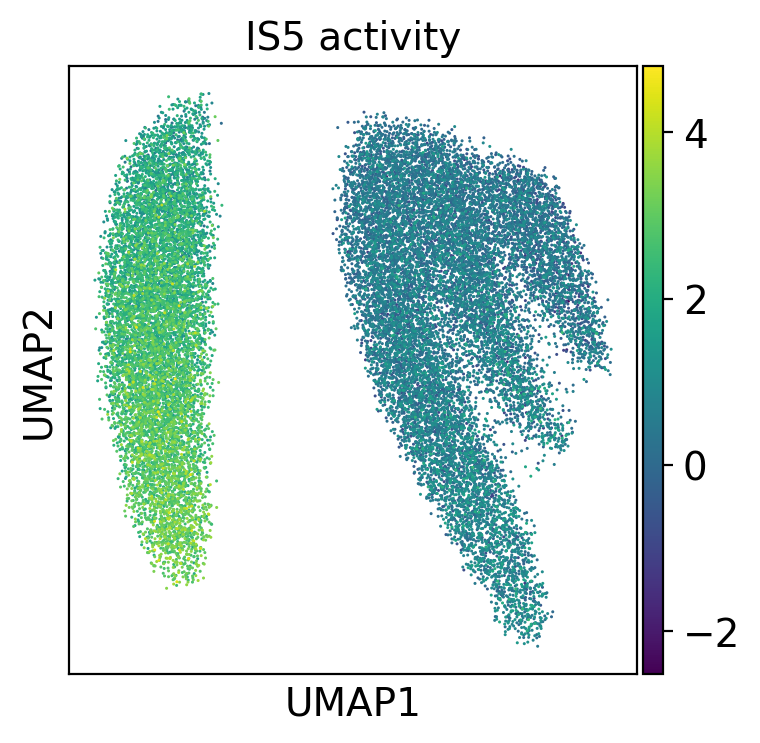

In [26]:
plot_imodulon_activity(adata, 'IS5')

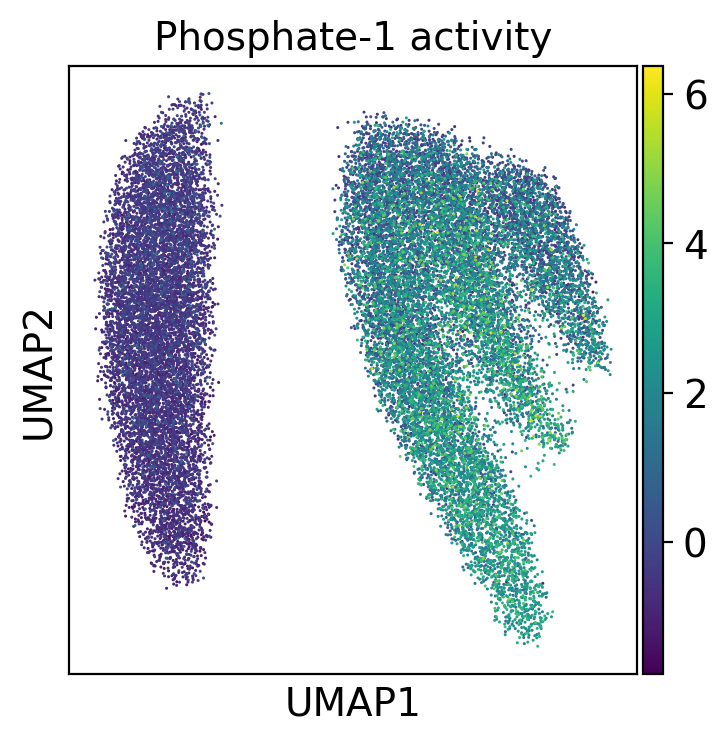

In [27]:
plot_imodulon_activity(adata, 'Phosphate-1')

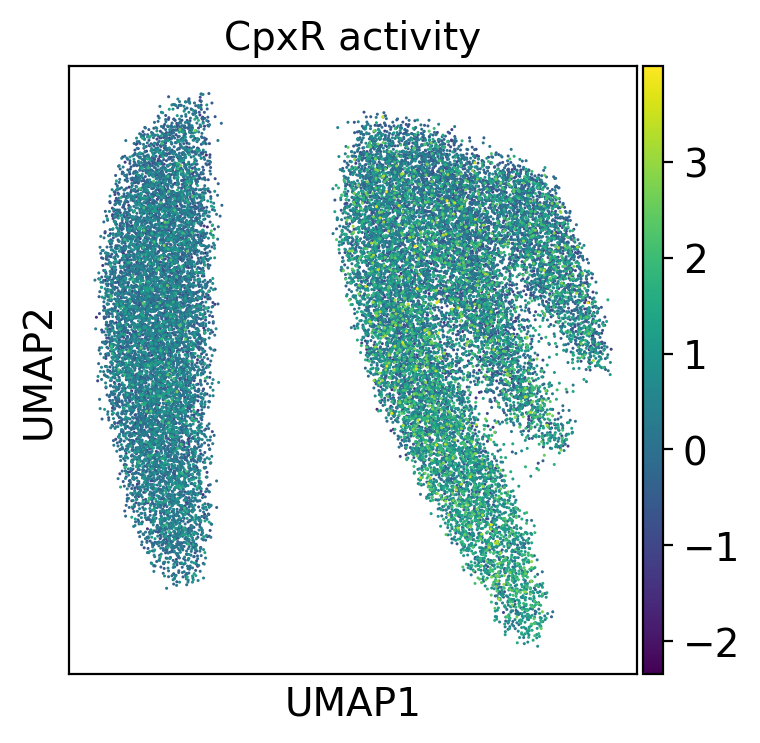

In [28]:
plot_imodulon_activity(adata, 'CpxR')